In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from bs4 import BeautifulSoup
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, RocCurveDisplay
)

# === 1. Load Data ===

In [2]:
# Load the CSV
df = pd.read_csv("completeSpamAssassin.csv")
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df.drop_duplicates(inplace=True)
df['Body'] = df['Body'].fillna('')

# === 2. Clean HTML and Non-English ===

In [3]:
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df['Body'] = df['Body'].apply(clean_html)
df = df[df['Body'].apply(is_english)]

/tmp/ipykernel_117860/3150450804.py:2: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  return BeautifulSoup(text, "html.parser").get_text()


# === 3. Visualize Label Distribution ===

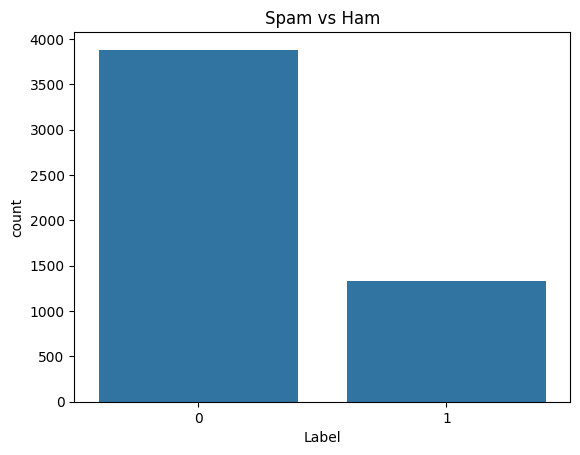

In [4]:
sns.countplot(data=df, x='Label')
plt.title('Spam vs Ham')
plt.show()

# === 4. Vectorization ===

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9)
X = vectorizer.fit_transform(df['Body'])
y = df['Label']


# === 5. Split Dataset ===

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train and Evaluate Logistic Reg and naives bayes

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


=== Logistic Regression ===
Accuracy: 0.9587727708533078
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       760
           1       1.00      0.85      0.92       283

    accuracy                           0.96      1043
   macro avg       0.97      0.92      0.95      1043
weighted avg       0.96      0.96      0.96      1043


=== Naive Bayes ===
Accuracy: 0.9079578139980825
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       760
           1       1.00      0.66      0.80       283

    accuracy                           0.91      1043
   macro avg       0.94      0.83      0.87      1043
weighted avg       0.92      0.91      0.90      1043


=== SVM ===
Accuracy: 0.975071907957814
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       760
           1       0.99      0.92      0.95       283

    accuracy                     

# === 7. SVM: Confusion Matrix and ROC Curve ===

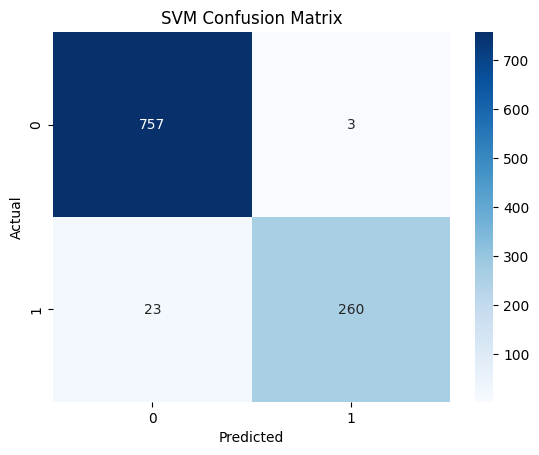

In [8]:
svm = models["SVM"]
y_pred_svm = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve

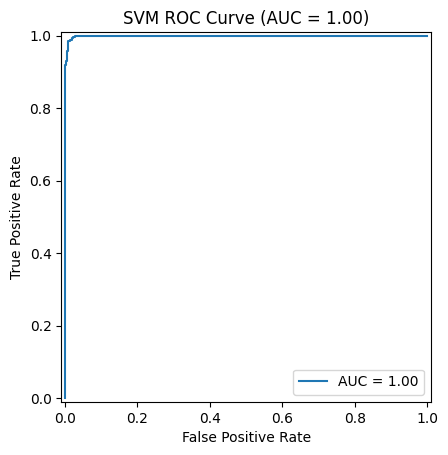

In [9]:
try:
    # LinearSVC does not have predict_proba, use decision_function instead
    y_scores = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(f"SVM ROC Curve (AUC = {roc_auc:.2f})")
    plt.show()
except Exception as e:
    print("ROC Curve not available:", e)

# === 8. Cross-Validation (5-Fold) ===

In [10]:
cv_scores = cross_val_score(svm, X, y, cv=5)
print("SVM Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

SVM Cross-Validation Scores: [0.97315436 0.97986577 0.98368522 0.98560461 0.93953935]
Mean CV Accuracy: 0.9723698617784592


# === 9. GridSearch for Hyperparameter Tuning (Optional for SVM) ===

In [11]:
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LinearSVC(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
best_svm = grid.best_estimator_

Best Params: {'C': 10}


# === 10. Save Model & Vectorizer ===

In [12]:
joblib.dump(svm, 'svm_spam_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("✅ Model and vectorizer saved.")

✅ Model and vectorizer saved.
